In [2]:
import scvelo as scv
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error


In [3]:
##### I should do some filtering... Originally: 13960 cells 8009 genes


# Load dataset, with velocity values
    # these values are all normalized by scvelo
vdata = sc.read_h5ad("velocity_adata.h5ad")



# Scale Ms and velocity layer, with mean=0 and unit variance 
    # sc.pp.scale adds mean and std to var, although this relfects only last scaling
    # here we add the velocity scaling to the spliced counts scaling

sc.pp.scale(vdata, layer='Ms')
sc.pp.scale(vdata, layer='velocity')

In [4]:
##### Split data into train and test
    # watch out for time-ordering, randomly choose cells
    # sc.pp.subsample might not work the way I want it to. Have to find another way to create real objects,
    # here only views are created -- not enough i believe, do not have access to the names ??

test, train = train_test_split(vdata, test_size=0.5)


In [5]:
##### linear regression with Klf2

#ADD R^2 SCORE Somewhere

tf='Klf2'

X_train = train.layers['velocity']
y_train = train[:, tf].layers['Ms']

X_test = test.layers['velocity']
y_test = test[:, tf].layers['Ms']


lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred = lin.predict(X_test)

In [21]:
##### p-value for Klf2 Regression
# If I calculate the p-values with all of these, then there is almost always NaN...

# Run this a couple of times and keep the top 100 or so genes each time to compare. 
from scipy import stats
import pandas as pd
import random 

# data

top = {}

for x in range(50):

    tf = 'Klf2'
    # starting at 7000, p-values are NaNs
    genes = random.sample(list(vdata.var_names), 4000)

    X_train = train[:,genes].layers['velocity']
    y_train = train[:, tf].layers['Ms']

    X_test = test[:, genes].layers['velocity']
    y_test = test[:, tf].layers['Ms']

    #regression
    lin = LinearRegression()
    lin.fit(X_train, y_train)
    params = np.append(lin.intercept_,lin.coef_)
    y_pred = lin.predict(X_test)


    delta_y = y_test - y_pred


    # Here we append, why though? appending (6847, 1) and (6847, 6000) on axis= 1, then we get (6847, 6001). Is this necessary? 
    # We are adding one column of 1 infront of everything? Why?
    newX = np.append(np.ones((len(X_test),1)), X_test, axis=1)
    MSE = (sum((delta_y**2)))/(len(newX)-len(newX[0]))
    #print(MSE)

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

    sd_b = np.round(sd_b,5)
    ts_b = np.round(ts_b,5)
    p_values = np.round(p_values,5)
    params = np.round(params,6)

    # I am not sure if this is right. Why do we need a column of 1s?
    names = ['1'] + genes

    myDF3 = pd.DataFrame()
    myDF3['Genes'],myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [names, params,sd_b,ts_b,p_values]
    sortedDF = myDF3.sort_values(by=['Probabilities']).copy()
    
    print(sortedDF)
    
    # so I want to keep a list of top 100 genes with p-value smaller than 0.05
    # I want to keep track of their coefficients -> should I save all of the coefficients? Or only focus on the coef. of genes always relevant? 
    # I want to plot the mean coef value of those genes. maybe along with how often it came up? color scale? 
    # i want to keep track of how often that gene has been under 0.05
    
    for g in sortedDF['Genes'][:50]:
        if g in top:
            top[g] += [myDF3.at[myDF3.index[myDF3['Genes']==g].item(), 'Coefficients']]
        else:
            top[g] = [myDF3.at[myDF3.index[myDF3['Genes']==g].item(), 'Coefficients']]
            
            #print(g, [myDF3.at[myDF3.index[myDF3['Genes']==g].item(), 'Coefficients']])
            
    
names = np.array(list(top.items()))[:, 0]
count = np.array([len(top[g]) for g in top.keys()])
coef = np.array(list(top.values()))
coefmean = np.array([sum(top[g]) / len(top[g]) for g in top.keys()])
#something missing here. have to actually calculate the mean.



countDF = pd.DataFrame()
countDF['Genes'], countDF['Count'], countDF['Coef Mean'], countDF['Coefficients'] = [names, count, coefmean, coef]
sDF = countDF.sort_values(by=['Count']).copy()
print(sDF)




         Genes  Coefficients  Standard Errors  t values  Probabilities
872       Klf2     -0.033125          0.01164  -2.84660        0.00445
168   Ppp1r13b      0.027972          0.01190   2.35037        0.01882
1305      Rgcc      0.032898          0.01450   2.26867        0.02336
2503      Mavs     -0.022847          0.01133  -2.01643        0.04385
593       Ccr5     -0.032661          0.01632  -2.00143        0.04544
...        ...           ...              ...       ...            ...
820      Phgdh      0.000013          0.01229   0.00108        0.99914
1269     Atp5s     -0.000011          0.01111  -0.00103        0.99918
3934     Ddx18     -0.000009          0.01151  -0.00079        0.99937
1866      Rrm1     -0.000007          0.01323  -0.00054        0.99957
69      Chmp4b      0.000005          0.01151   0.00040        0.99968

[4001 rows x 5 columns]
         Genes  Coefficients  Standard Errors  t values  Probabilities
3671   Rasgrp2     -0.086524          0.02179  -3.97

        Genes  Coefficients  Standard Errors  t values  Probabilities
877   Rasgrp2     -0.081339          0.02189  -3.71573        0.00021
448    Slc9a7      0.044004          0.01619   2.71840        0.00660
2613     Gas7      0.029008          0.01318   2.20101        0.02782
1562    Cpeb2      0.024287          0.01200   2.02350        0.04311
3540    Fbxl2      0.024743          0.01248   1.98207        0.04757
...       ...           ...              ...       ...            ...
2765   Exosc1     -0.000011          0.01192  -0.00092        0.99927
1458      Spn     -0.000009          0.01107  -0.00081        0.99935
3070     Hps3      0.000007          0.01070   0.00066        0.99947
1372    Ccne1     -0.000008          0.01352  -0.00060        0.99952
3006     Rbm3     -0.000000          0.01219  -0.00002        0.99999

[4001 rows x 5 columns]
              Genes  Coefficients  Standard Errors  t values  Probabilities
584         Rasgrp2     -0.077965          0.02189  -3.5616

         Genes  Coefficients  Standard Errors  t values  Probabilities
3810   Krtcap3      0.024160          0.01119   2.15897        0.03094
1241  Hsp90aa1     -0.089549          0.04318  -2.07391        0.03818
1767    Pnpla8      0.022718          0.01135   2.00112        0.04547
1614     Taf10      0.019550          0.01028   1.90215        0.05725
1305     l7Rn6      0.022325          0.01189   1.87783        0.06051
...        ...           ...              ...       ...            ...
1691      Pym1      0.000005          0.01134   0.00042        0.99966
3158     Ywhaq     -0.000004          0.01182  -0.00034        0.99973
3062      Atf6     -0.000003          0.01227  -0.00028        0.99978
2852      Cuta     -0.000002          0.01142  -0.00021        0.99983
2334     Suz12      0.000001          0.01213   0.00005        0.99996

[4001 rows x 5 columns]
        Genes  Coefficients  Standard Errors  t values  Probabilities
938      Gas7      0.034780          0.01329   2.6173

        Genes  Coefficients  Standard Errors  t values  Probabilities
3836  Rasgrp2     -0.073372          0.02168  -3.38427        0.00072
1159     Atf3      0.027393          0.01294   2.11631        0.03440
3915     Rgcc      0.028516          0.01461   1.95123        0.05113
709     Gpr65      0.022173          0.01160   1.91065        0.05615
3107    Tesk2     -0.027545          0.01454  -1.89466        0.05824
...       ...           ...              ...       ...            ...
233    Pet100     -0.000014          0.01163  -0.00119        0.99905
2818     Tfeb      0.000010          0.01138   0.00091        0.99927
3664    Art2b     -0.000003          0.01159  -0.00027        0.99979
3735   Spata5     -0.000002          0.01234  -0.00018        0.99986
3554   Gemin7     -0.000001          0.01140  -0.00012        0.99990

[4001 rows x 5 columns]
        Genes  Coefficients  Standard Errors  t values  Probabilities
954   Rasgrp2     -0.078322          0.02185  -3.58492        0.0

              Genes  Coefficients  Standard Errors  t values  Probabilities
3141           Klf2     -0.034148          0.01226  -2.78556        0.00538
860          Slc9a7      0.032763          0.01610   2.03468        0.04198
290           Rbm26      0.028608          0.01537   1.86076        0.06288
2578          Cd101     -0.021762          0.01247  -1.74581        0.08095
2630          Mon1a     -0.019717          0.01158  -1.70269        0.08874
...             ...           ...              ...       ...            ...
3815       Rnaseh2a     -0.000011          0.01202  -0.00091        0.99927
3856         Cd2bp2      0.000009          0.01196   0.00072        0.99943
3409           Phc2     -0.000006          0.01194  -0.00051        0.99960
2365  2900026A02Rik      0.000005          0.01244   0.00040        0.99968
65            Acsl4     -0.000001          0.01211  -0.00011        0.99991

[4001 rows x 5 columns]
        Genes  Coefficients  Standard Errors  t values  Probabi

(array([  2.,   0.,   3.,  46., 510.,   0., 508., 101.,   2.,   2.]),
 array([-0.0787445 , -0.06455022, -0.05035593, -0.03616165, -0.02196737,
        -0.00777308,  0.0064212 ,  0.02061548,  0.03480977,  0.04900405,
         0.06319833]),
 <BarContainer object of 10 artists>)

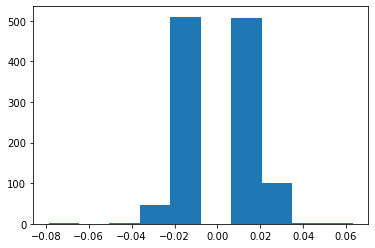

In [22]:

#sometimes more data is better, sometimes less ;
# figure out how the histogram is meant to be
# and how to limit the numbers to significance value under 0.05.
# and which number of genes is best.
# Why do the p-values increase as more genes are used? w/ 6000 we dont get under 0.60..
# with 4000 we got 729 different genes. not too bad
# Rasgrp2
plt.hist(countDF['Coef Mean'].to_numpy())

In [23]:
df = pd.DataFrame()
df['Names'], df['Numbers'] = [['a', 'b', 'c', 'd'], [1, 2, 3, 4]]
df.at[df.index[df['Names']=='b'].item(), 'Numbers']


2

In [1]:
d = {'a': {'coef': [4, 5, 6], 'count': 1}, 'b':{'coef': [1, 1, 1], 'count': 2}}
d['a']['coef']+=[1]
[sum(d[x]['coef']) / len(d[x]['coef']) for x in d.keys()]

[4.0, 1.0]

In [16]:
##### Scatter Plotting linear Regression from velocity to one tf values
### returns regression

 # run regression, evaluate regression (test accuracy and residauls), identify genes that are relevant, 
    

def velocity_tf_regression_and_scatter_plot(train, test, tf):
    
    # data
    X_train = train.layers['velocity']
    y_train = train[:, tf].layers['Ms']
    
    X_test = test.layers['velocity']
    y_test = test[:, tf].layers['Ms']
    
    
    lin = LinearRegression()
    lin.fit(X_train, y_train)
    y_pred = lin.predict(X_test)
    
    
    delta_y = y_test - y_pred
    squared_error = np.power(delta_y, 2)
    
    min_y = min(y_test)
    max_y = max(y_test)
    
    
    
    # plot true values vs predicted
    plt.figure()
    plt.hexbin(y_test, y_pred)
    plt.plot([min_y, max_y], [min_y, max_y], ls="--", c=".3")
    
    
    # plot labels
    plt.title(str(tf)+' true values vs prediction')
    plt.xlabel('True Values')
    plt.ylabel('Prediction')
    plt.show()
    
    # plot true values vs squared error
    plt.figure()
    plt.scatter(y_test, squared_error, marker='o', color='lightgreen')
    
    # plot labels
    plt.title(str(tf)+' true values vs squared error')
    plt.xlabel('True Values')
    plt.ylabel('Error score')
    plt.show()
    
    # plot true values vs delta y and y_pred
    plt.figure()
    plt.hist(delta_y)
    
    # plot labels
    plt.title(str(tf)+' true values vs y-y_pred')
    plt.xlabel('True Values')
    plt.ylabel('Error score')
    plt.show()
    
    return lin, y_pred


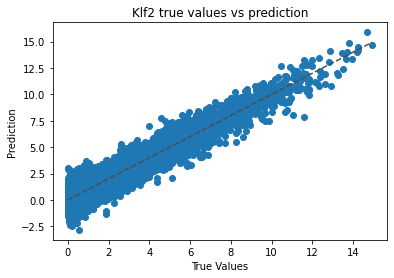

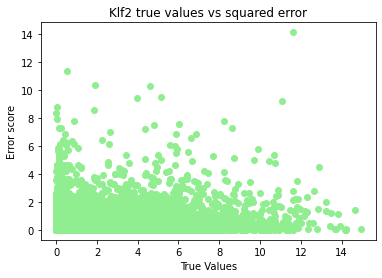

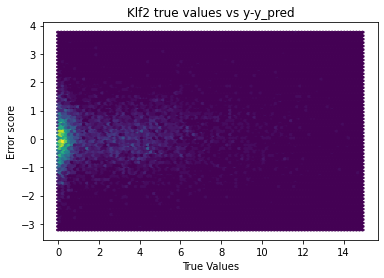

KeyboardInterrupt: 

In [5]:
##### plotting true vs predicted values and true vs error of each tf

for tf in ['Klf2', 'Mcm3', 'Mcm5', 'Hmgb2', 'Cdk4', 'Hif1a', 'Mcm6', 'Tox']:
    velocity_tf_regression_and_scatter_plot(train, test, tf)

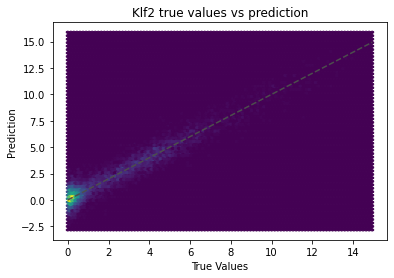

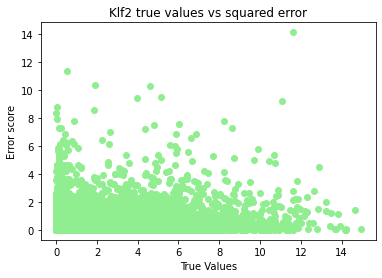

Trying to set attribute `.layers` of view, copying.
Trying to set attribute `.layers` of view, copying.
Trying to set attribute `.layers` of view, copying.


ValueError: shape mismatch: value array of shape (0,) could not be broadcast to indexing result of shape (0,1)

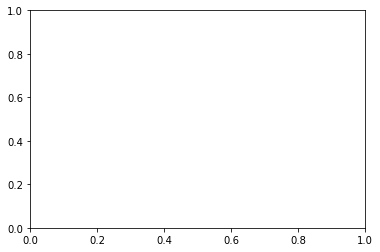

In [17]:
lin, y_pred = velocity_tf_regression_and_scatter_plot(train, test, 'Klf2')

In [11]:
#Papa sagt doch gaus verteilt? ????
(y_pred-test[:, 'Klf2'].layers['Ms'].toarray().flatten()).shape

(6847, 6847)

(array([6953., 1932., 2026., 1390.,  641.,  328.,  229.,  132.,   45.,
          18.]),
 array([-0.9356508 , -0.36637115,  0.20290852,  0.7721882 ,  1.3414679 ,
         1.9107475 ,  2.4800272 ,  3.0493069 ,  3.6185865 ,  4.187866  ,
         4.757146  ], dtype=float32),
 <BarContainer object of 10 artists>)

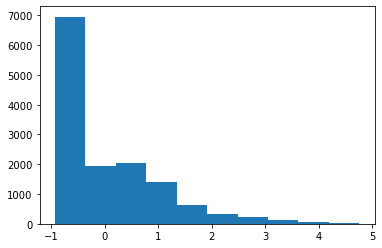

In [83]:
# not symetrical distribution
plt.hist(vdata[:,'Klf2'].layers['Ms'].toarray().flatten())


In [8]:
##### p-value for Klf2 Regression
# If I calculate the p-values with all of these, then there is almost always NaN...

# Run this a couple of times and keep the top 100 or so genes each time to compare. 
from scipy import stats
import pandas as pd
import random 

# data

top = {}

for x in range(50):

    tf = 'Klf2'
    # starting at 7000, p-values are NaNs
    genes = random.sample(list(vdata.var_names), 6000)

    X_train = train[:,genes].layers['velocity']
    y_train = train[:, tf].layers['Ms']

    X_test = test[:, genes].layers['velocity']
    y_test = test[:, tf].layers['Ms']


    lin = LinearRegression()
    lin.fit(X_train, y_train)
    y_pred = lin.predict(X_test)


    delta_y = y_test - y_pred


    print('graph done.')


    # Here we append, why though? appending (6847, 1) and (6847, 6000) on axis= 1, then we get (6847, 6001). Is this necessary? 
    # We are adding one column of 1 infront of everything? Why?
    newX = np.append(np.ones((len(X_test),1)), X_test, axis=1)
    MSE = (sum((delta_y**2)))/(len(newX)-len(newX[0]))
    print(MSE)

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

    sd_b = np.round(sd_b,5)
    ts_b = np.round(ts_b,5)
    p_values = np.round(p_values,5)
    params = np.round(params,6)

    # I am not sure if this is right. Why do we need a column of 1s?
    names = ['1']+ genes

    myDF3 = pd.DataFrame()
    myDF3['Genes'],myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [names, params,sd_b,ts_b,p_values]
    sortedDF = myDF3.sort_values(by=['Probabilities'], ascending=False).copy()
    
    print(sortedDF)
    
    for g in sortedDF['Genes'][:100]:
        if g in top:
            top[g] += 1
        else:
            top[g]=1
    
names = np.array(list(top.items()))[:, 0]
count = np.array(list(top.items()))[:, 1]

countDF = pd.DataFrame()
countDF['Genes'], countDF['Count'] = [names, count]





graph done.
[0.86177504]


NameError: name 'params' is not defined

In [70]:
a = np.array(tippi)


array([['Fbxo31', '2'],
       ['Ksr1', '1'],
       ['Lancl2', '1'],
       ...,
       ['Dcun1d3', '1'],
       ['Ptpn11', '1'],
       ['Supt20', '1']], dtype='<U13')

In [35]:
# run p_values 20 times, saving the top 50 genes


216        Glb1
791     Syncrip
5260     Mrps26
1156    Dennd1b
1174     Nfkbie
         ...   
2012       Pus1
708     Gm11998
5991       Pld3
4488      Fars2
2379    Rasgrp2
Name: Genes, Length: 6001, dtype: object

In [39]:
#Import q values
# Still have to import it (download, etc)
import qvalue

qv = qvalue.estimate(myDF3['Probabilities'])

ModuleNotFoundError: No module named 'qvalue'

In [17]:
# Vulcano Plot for Klf2 with p-values

# fold change



(1, 6000)

In [ ]:
##### Run regression 10x with random gene samples
import random

tf = ['Klf2', 'Mcm3', 'Mcm5', 'Hmgb2', 'Cdk4', 'Hif1a', 'Mcm6', 'Tox']

for n in range(10):
    velocities = random.sample(list(vdata.var_names), 8)
    
    #tf_velocity_regression_and_scatter_plot(train, test, tf, velocities)
    

In [ ]:
##### Run regression 10x with one gene sample, save coeficients

tf = ['Klf2', 'Mcm3', 'Mcm5', 'Hmgb2', 'Cdk4', 'Hif1a', 'Mcm6', 'Tox']
genes = ['Peli1', 'Mettl3', 'Cdca2', 'Crebzf', 'Tmod3', 'Ino80d', 'Malt1', 'Hnrnpul2']
coef = []

for n in range(10):
    #lin = tf_velocity_regression_and_scatter_plot(train, test, tf, genes)
    coef.append(lin.coef_)
    
# calculate mean,


In [8]:
##### Plotting coeficients, if they change..
import numpy as np 

total = np.zeros((8,8))

# mean
for x in coef:
    total = total + np.array(x)
mean = total / 8
print(mean)

subsum = np.zeros((8,8))

# standard deviation,
# I guess this is the variance in each direction? not sure which gene corrensponds to which gene, nor how to plot it..
for x in coef:
    subsum += np.power((np.array(x)-mean), 2)
sd = np.sqrt(subsum / 8)
print(sd)


[[-0.22249587 -0.37397448 -0.02990348 -0.07513822  0.17961394 -0.14046459
   0.30319395 -0.32646384]
 [-0.12774846  0.00614363 -0.18816158 -0.08482389 -0.16990591  0.05666545
   0.24398094 -0.15143747]
 [-0.02402513  0.32171354  0.46241086 -0.17398188 -0.00174484 -0.00440166
  -0.31561043 -0.05915332]
 [-0.14286362 -0.11821478  0.2505176   0.06369115  0.31147007  0.0045556
  -0.07086317 -0.10194501]
 [-0.10375874  0.07178156 -0.12496241 -0.22377523 -0.08865817 -0.17484671
  -0.13464102 -0.1714085 ]
 [-0.12251852  0.18213632 -0.46677765  0.17978588 -0.20981105 -0.00414686
   0.26781825 -0.36115255]
 [-0.18003535 -0.21520074  0.34082934 -0.05823979 -0.53522527 -0.10308014
   0.09488421 -0.27832821]
 [-0.14805102 -0.15861737 -0.01769755 -0.03969091  0.04714265  0.01588401
   0.06000024 -0.11322808]]
[[0.04975159 0.08362324 0.00668662 0.01680142 0.0401629  0.03140884
  0.06779623 0.07299953]
 [0.02856542 0.00137376 0.04207421 0.0189672  0.03799212 0.01267078
  0.0545558  0.03386245]
 [0.00

In [ ]:
##### From transcriptionfactors to velocity, regress a couple of times to one velocity

    # one velocity value -> would be 8000 scatter plots
    # --> plot all errors (predicted vs actual together), should be okay with scale
    # take predicted and acutal value and test if they are significantly different or not (pvalue for each regression)
    #-> plot for each tf and gene, see which are related
   

    tf = ['Klf2', 'Mcm3', 'Mcm5', 'Hmgb2', 'Cdk4', 'Hif1a', 'Mcm6', 'Tox']

#does not work, becuase x and y are not the same size.
#tf_velocity_regression_and_scatter_plot(test, train, tf, 'Mettl3')

for size in range(5):
    
    # with all values!
    txn_values = X_train.layers['Ms']
    

    # thin
    velocity_values = vdata.layers['velocity']

    
    plt.figure()
    #plt.scatter(velocity_values, txn_values)
    
    # plot labels
    plt.title('Relationship between '+txn+' and Velocity')
    plt.ylabel(txn)
    plt.xlabel('Velocity')
    
    
    # linear fit
    lin.fit(txn_values, velocity_values)
    velocity_y_pred = lin.predict(txn_values)
    

    plt.scatter(velocity_values, velocity_y_pred)
    
    plt.plot(velocity_values, velocity_y_pred, color='red')
    
    print("This is the intercept for ",txn,' ', lin.intercept_)
    print("These are the coefficients ", lin.coef_)
    print("So viele coef gibt es", lin.coef_.size)

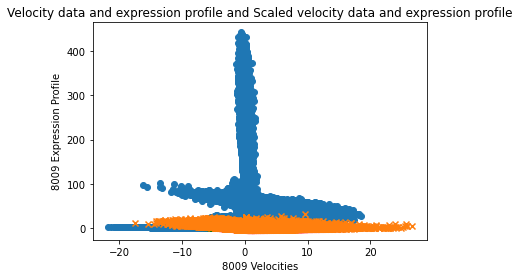

In [8]:
##### Comparing scaled data and non-scaled data

# reloading dataset, just to compare
ndata = sc.read_h5ad("velocity_adata.h5ad")

plt.figure()
plt.title('Velocity data and expression profile and Scaled velocity data and expression profile')
plt.xlabel('8009 Velocities')
plt.ylabel('8009 Expression Profile')

plt.scatter(ndata.layers['velocity'], ndata.layers['Ms'], marker='o')
plt.scatter(vdata.layers['velocity'], vdata.layers['Ms'], marker='x')

plt.show()

In [ ]:
##### Distribution of test data and training data

plt.figure()
plt.title('Distribution of testing and training data')
plt.xlabel('8009 Velocities')
plt.ylabel('8009 Expression Profile')

# what is the default if more dimensions?
plt.scatter(test.layers['velocity'], test.layers['Ms'], marker='o')
plt.scatter(train.layers['velocity'], train.layers['Ms'], marker='x')

plt.show()
